# Распознавание текста

## CRNN+CTC loss baseline

В данном ноутбуке представлен baseline модели распознавания текста с помощью CRNN модели и CTC loss. Вы можете добавить новые аугментации или изменить структуру данной модели, или же попробовать совершенно новую архитектуру.

# 0. Установка и подгрузука библиотек

In [ ]:
!pip install torch torchvision --quiet
!pip install -U git+https://github.com/facebookresearch/detectron2.git
!pip install opencv-python matplotlib pandas scikit-learn --quie

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-n15qc6sn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-n15qc6sn
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done


In [5]:
 !pip install numpy==1.20.3
 !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
 !pip install opencv-python==4.5.2.52
 !pip install matplotlib==3.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (numpy)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu111 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.

Установка библиотек, под которым запускается данный бейзлайн.

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.7 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
# from jiwer import wer
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt

## 1. Разделим трейн датасет на обучающую и валидационную подвыборки


Сначала преобразуем таблицу (в которой есть колонка base_image) в `labels.json` - это формат из второго этапа олимпиады, для которого составлялся бейзлайн. По сути это просто словарь из колонок 'file_name' и 'text'.

In [ ]:
import pandas as pd

In [43]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [49]:
import zipfile

zip_path = '/content/drive/MyDrive/train_recognition_small.zip'
extract_to = '/content/drive/MyDrive'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [50]:
import pandas as pd
import os

df_path = '/content/drive/MyDrive/train_recognition_small'
train_csv = pd.read_csv(os.path.join(df_path, 'labels_small.csv'))
images_folder = os.path.join(df_path, 'images')
available_files = set(os.listdir(images_folder))
train_csv = train_csv[train_csv['file_name'].isin(available_files)].reset_index(drop=True)
train_data = dict(train_csv[['file_name', 'text']].values)
print("Итоговая длина train_data:", len(train_data))

Итоговая длина train_data: 6000


In [51]:
train_data = [(k, v) for k, v in train_data.items()]
print('train len', len(train_data))

split_coef = 0.75
train_len = int(len(train_data)*split_coef)

train_data_splitted = train_data[:train_len]
val_data_splitted = train_data[train_len:]

print('train len after split', len(train_data_splitted))
print('val len after split', len(val_data_splitted))

train len 6000
train len after split 4500
val len after split 1500


In [52]:
with open('/content/drive/MyDrive/train_recognition_small/train_labels_splitted.json', 'w') as f:
    json.dump(dict(train_data_splitted), f)

with open('/content/drive/MyDrive/train_recognition_small/val_labels_splitted.json', 'w') as f:
    json.dump(dict(val_data_splitted), f)

## 2. Зададим параметры обучения

Здесь мы можем поправить конфиги обучения - задать размер батча, количество эпох, размер входных изображений, а также установить пути к датасетам.

In [ ]:
alphabet = ''.join(sorted(list(set(''.join(train_csv['text'].values)))))

In [ ]:
alphabet

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


config_json = {
    "alphabet": ''' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№''',
    "save_dir": "experiments/test",
    "num_epochs": 120,
    "image": {
        "width": 256,
        "height": 32
    },
    "train": {
        "root_path": "/content/drive/MyDrive/train_recognition_small/images/",
        "json_path": "/content/drive/MyDrive/train_recognition_small/train_labels_splitted.json",
        "batch_size": 64
    },
    "val": {
        "root_path": "/content/drive/MyDrive/train_recognition_small/images/",
        "json_path": "/content/drive/MyDrive/train_recognition_small/val_labels_splitted.json",
        "batch_size": 64
    }
}

In [ ]:
DEVICE

device(type='cuda')

## 3. Теперь определим класс датасета (torch.utils.data.Dataset) и другие вспомогательные функции

In [ ]:
# функция которая помогает объединять картинки и таргет-текст в батч
def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens


def get_data_loader(
    transforms, json_path, root_path, tokenizer, batch_size, drop_last
):
    dataset = OCRDataset(json_path, root_path, tokenizer, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=8,
    )
    return data_loader


class OCRDataset(Dataset):
    def __init__(self, json_path, root_path, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.data_len = len(data)

        self.img_paths = []
        self.texts = []
        for img_name, text in data.items():
            self.img_paths.append(os.path.join(root_path, img_name))
            self.texts.append(text)
        self.enc_texts = tokenizer.encode(self.texts)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        # print("Путь к изображению:", img_path)
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx])
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, text, enc_text


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## 4. Здесь определен Токенайзер - вспопогательный класс, который преобразует текст в числа

Разметка-текст с картинок преобразуется в числовое представление, на которых модель может учиться. Также может преобразовывать числовое предсказание модели обратно в текст.

In [10]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

## 5. Accuracy в качестве метрики

Accuracy измеряет долю предсказанных строк текста, которые полностью совпадают с таргет текстом.

In [ ]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

In [ ]:
from jiwer import cer

def get_cer(true_texts, pred_texts):
    total_cer = 0.0
    for true, pred in zip(true_texts, pred_texts):
        total_cer += cer(true, pred)
    return total_cer / len(true_texts)

## 6. Аугментации

Здесь мы задаем базовые аугментации для модели. Вы можете написать свои или использовать готовые библиотеки типа albumentations

In [34]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        if image is None:
          raise FileNotFoundError("OpenCV не смог загрузить изображение (None)")
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image



def get_train_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

## 7. Здесь определяем саму модель - CRNN

Подробнее об архитектуре можно почитать в статье https://arxiv.org/abs/1507.05717

In [12]:
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

## 8. Переходим к самому скрипту обучения - циклы трейна и валидации

In [4]:
# def val_loop(data_loader, model, tokenizer, device):
#     acc_avg = AverageMeter()
#     #for images, texts, _, _ in data_loader:
#     #    batch_size = len(texts)
#     #    text_preds = predict(images, model, tokenizer, device)
#     #    acc_avg.update(get_accuracy(texts, text_preds), batch_size)
#     #print(f'Validation, acc: {acc_avg.avg:.4f}')
#     #return acc_avg.avg
#     model.eval()
#     with torch.no_grad():  #Выключаем градиенты
#         for images, texts, _, _ in data_loader:
#             batch_size = len(texts)
#             text_preds = predict(images, model, tokenizer, device)
#             acc_avg.update(get_accuracy(texts, text_preds), batch_size)
#     print(f'Validation, acc: {acc_avg.avg:.4f}')
#     return acc_avg.avg

def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    cer_total = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for images, texts, _, _ in data_loader:
            batch_size = len(texts)
            text_preds = predict(images, model, tokenizer, device)

            acc = get_accuracy(texts, text_preds)
            acc_avg.update(acc, batch_size)

            cer_total += get_cer(texts, text_preds) * batch_size
            total_samples += batch_size

    cer_avg = cer_total / total_samples
    print(f'Validation, acc: {acc_avg.avg:.4f}, CER: {cer_avg:.4f}')
    return acc_avg.avg, cer_avg


# def train_loop(data_loader, model, criterion, optimizer, epoch):
#     loss_avg = AverageMeter()
#     model.train()
#     for images, texts, enc_pad_texts, text_lens in data_loader:
#         model.zero_grad()
#         images = images.to(DEVICE)
#         batch_size = len(texts)
#         output = model(images)
#         output_lenghts = torch.full(
#             size=(output.size(1),),
#             fill_value=output.size(0),
#             dtype=torch.long
#         )
#         loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
#         loss_avg.update(loss.item(), batch_size)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
#         optimizer.step()
#     for param_group in optimizer.param_groups:
#         lr = param_group['lr']
#     print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
#     return loss_avg.avg

def train_loop(data_loader, model, criterion, optimizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    for images, texts, enc_pad_texts, text_lens in data_loader:
        model.zero_grad()
        images = images.to(DEVICE)
        batch_size = len(texts)

        output = model(images)
        output_lengths = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )

        loss = criterion(output, enc_pad_texts, output_lengths, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg


# def predict(images, model, tokenizer, device):
#     model.eval()
#     images = images.to(device)
#     with torch.no_grad():
#         output = model(images)
#     pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
#     text_preds = tokenizer.decode(pred)
#     return text_preds

def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)  # [T, B, C]
    logits = output.detach().cpu()
    pred_indices = torch.argmax(logits, dim=-1)  # [T, B]
    pred_indices = pred_indices.permute(1, 0).numpy()  # [B, T]

    # CTC decoding: remove duplicates and blanks (index 0 assumed to be blank)
    decoded = []
    for seq in pred_indices:
        prev = -1
        out = []
        for idx in seq:
            if idx != prev and idx != 0:
                out.append(idx)
            prev = idx
        decoded.append(tokenizer.decode([out]))
    return decoded


def get_loaders(tokenizer, config):
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    train_loader = get_data_loader(
        json_path=config['train']['json_path'],
        root_path=config['train']['root_path'],
        transforms=train_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True
    )
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    val_loader = get_data_loader(
        transforms=val_transforms,
        json_path=config['val']['json_path'],
        root_path=config['val']['root_path'],
        tokenizer=tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=False
    )
    return train_loader, val_loader


# def train(config):
#     tokenizer = Tokenizer(config['alphabet'])
#     os.makedirs(config['save_dir'], exist_ok=True)
#     train_loader, val_loader = get_loaders(tokenizer, config)

#     model = CRNN(number_class_symbols=tokenizer.get_num_chars())
#     model.to(DEVICE)

#     criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
#                                   weight_decay=0.01)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer=optimizer, mode='max', factor=0.5, patience=15)
#     best_acc = -np.inf
#     acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
#     for epoch in range(config['num_epochs']):
#         loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
#         acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
#         scheduler.step(acc_avg)
#         if acc_avg > best_acc:
#             best_acc = acc_avg
#             model_save_path = os.path.join(
#                 config['save_dir'], f'model-{epoch}-{acc_avg:.4f}.ckpt')
#             torch.save(model.state_dict(), model_save_path)
#             print('Model weights saved')


def train(config):
    tokenizer = Tokenizer(config['alphabet'])
    os.makedirs(config['save_dir'], exist_ok=True)
    train_loader, val_loader = get_loaders(tokenizer, config)

    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    model.to(DEVICE)

    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='max', factor=0.5, patience=15)

    best_acc = -np.inf
    history = []

    acc_avg, cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)  # ← обновлённый val_loop

    for epoch in range(config['num_epochs']):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg, cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)
        scheduler.step(acc_avg)

        history.append({
            "epoch": epoch,
            "loss": loss_avg,
            "accuracy": acc_avg,
            "cer": cer_avg
        })

        if acc_avg > best_acc:
            best_acc = acc_avg
            model_save_path = os.path.join(
                config['save_dir'], f'model-{epoch}-{acc_avg:.4f}.ckpt')
            torch.save(model.state_dict(), model_save_path)
            print('Model weights saved')

    # === Визуализация после обучения ===
    df_history = pd.DataFrame(history)

    plt.figure(figsize=(10, 4))
    plt.plot(df_history["epoch"].to_numpy(), df_history["accuracy"].to_numpy(), label="Accuracy")
    plt.plot(df_history["epoch"].to_numpy(), df_history["cer"].to_numpy(), label="CER")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Validation Accuracy & CER")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # График Loss
    plt.figure(figsize=(10, 4))
    plt.plot(df_history["epoch"].to_numpy(), df_history["loss"].to_numpy(), color="red", label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #     # === Сохранение истории метрик в CSV ===
    # history_path = os.path.join(config['save_dir'], "training_history.csv")
    # df_history.to_csv(history_path, index=False)
    # print(f"\n📁 История обучения сохранена: {history_path}")

## 9. Запускаем обучение!

In [ ]:
import numpy as np

np.Inf = np.inf

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Validation, acc: 0.0000, CER: 1.2776

Epoch 0, Loss: 143.81783, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000
Model weights saved

Epoch 1, Loss: 4.64555, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000

Epoch 2, Loss: 4.25414, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000

Epoch 3, Loss: 4.06039, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000

Epoch 4, Loss: 3.97796, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000

Epoch 5, Loss: 3.99695, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000

Epoch 6, Loss: 3.87821, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000

Epoch 7, Loss: 3.85231, LR: 0.0010000
Validation, acc: 0.0000, CER: 1.0000

Epoch 8, Loss: 3.78274, LR: 0.0010000
Validation, acc: 0.0000, CER: 0.9630

Epoch 9, Loss: 3.73292, LR: 0.0010000
Validation, acc: 0.0000, CER: 0.9062

Epoch 10, Loss: 3.75127, LR: 0.0010000
Validation, acc: 0.0000, CER: 0.9062

Epoch 11, Loss: 3.68237, LR: 0.0010000
Validation, acc: 0.0000, CER: 0.9062

Epoch 12, Loss: 3.65992, L

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword ar

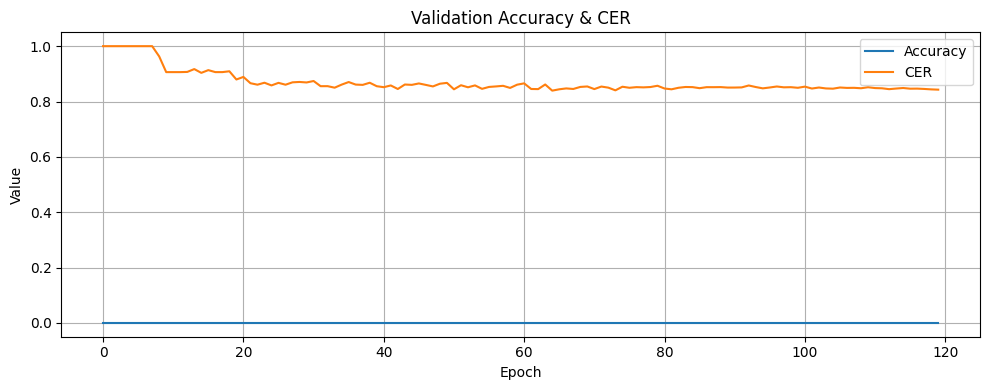

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword ar

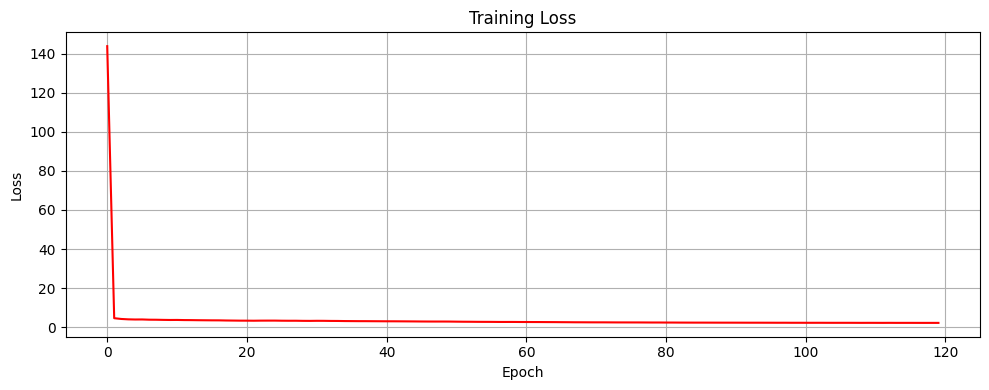


📁 История обучения сохранена: experiments/test/training_history.csv


In [ ]:
train(config_json)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {config['save_dir'] + '/logs'}

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2025-05-06 17:11:05.323473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746551465.345594   42605 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746551465.351996   42605 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--gr

## 10. Создание предсказаний для public-датасета

Сначала определим класс для создания предсказаний

In [1]:
class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cpu'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

Инициализируем OCR predictor

In [30]:
!rm -rf /content/drive

In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
!cp /content/drive/MyDrive/ocr-model-last.ckpt ocr-model-last.ckpt

In [35]:
predictor = OcrPredictor(
    model_path='ocr-model-last.ckpt',
    config=config_json,
    device='cpu'
)

Посмотрим несколько предсказаний и создадим финальный json

In [76]:
from google.colab import files
uploaded = files.upload()

Saving 18_0.JPG to 18_0.JPG


In [77]:
image_path = '/content/18_0.JPG'
img = cv2.imread(image_path)

In [78]:
import cv2
import matplotlib.pyplot as plt

def predict_on_image(image_path, predictor, show_image=True):
    """
    Загружает изображение, делает предсказание и (опционально) отображает его.

    Args:
        image_path (str): Путь к изображению.
        predictor (callable): Функция или объект, который принимает изображение и возвращает предсказание.
        show_image (bool): Показывать ли изображение.

    Returns:
        pred: Результат предсказания.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение по пути: {image_path}")

    pred = predictor(img)

    if show_image:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title("Your Image")
        plt.show()

    print("Prediction:", pred)
    return pred

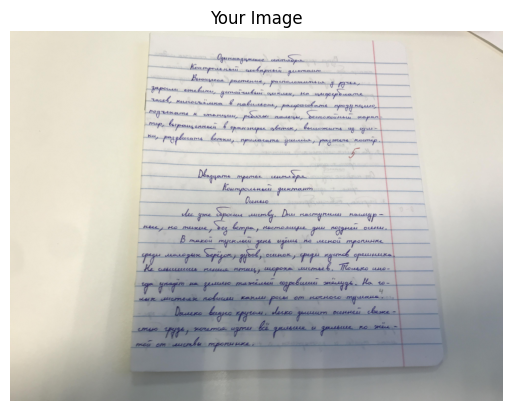

Prediction: ['та']


['та']

In [80]:
predict_on_image('/content/18_0.JPG', predictor)

In [36]:
import numpy as np
np.Inf = np.inf

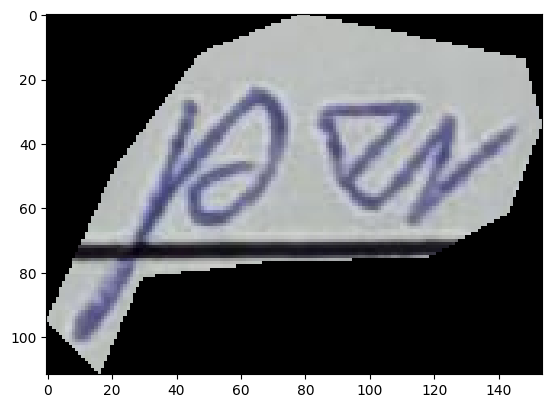

Prediction:  ['рак']
True:  por


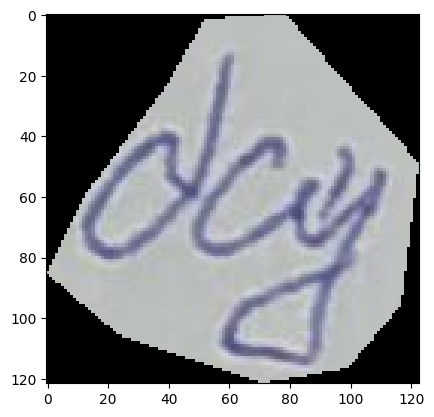

Prediction:  ['су']
True:  day


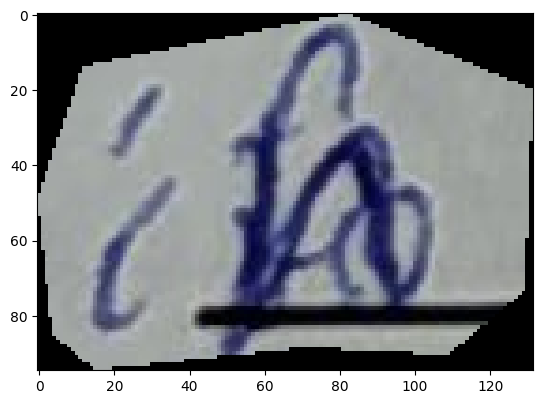

Prediction:  ['i0']
True:  if


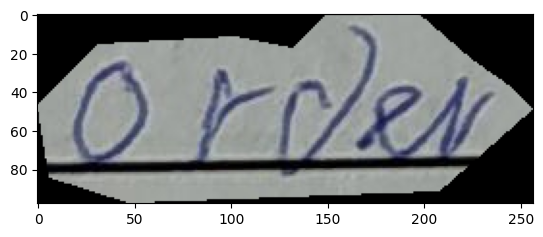

Prediction:  ['order']
True:  order


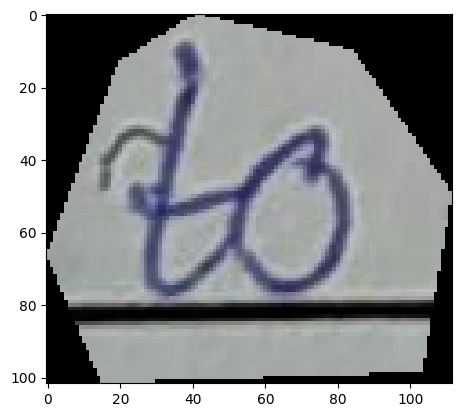

Prediction:  ['to']
True:  to


In [74]:
pred_json = {}

print_images = True
for val_img in val_data_splitted[10:15]:
    img = cv2.imread(f'/content/drive/MyDrive/train_recognition_small/images/{val_img[0]}')

    pred = predictor(img)
    pred_json[val_img[0]] = pred

    if print_images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        print('Prediction: ', predictor(img))
        print('True: ', val_img[1])


Сохраням submission json с предсказаниями

In [75]:
with open('prediction_HTR.json', 'w') as f:
    json.dump(pred_json, f)